# Inspect the Point-Source Visibility Simulations

In [1]:
from pyradiosky import SkyModel
from pyuvdata.uvdata import FastUVH5Meta
import numpy as np
from pathlib import Path
import h5py
import sys
import matplotlib.pyplot as plt
from scipy.signal import blackmanharris

In [2]:
sys.path.append("..")

In [3]:
from core import utils

In [5]:
utils.VIS_DIRFMT

'{sky_model}/nt17280-{chunks:03d}chunks'

In [12]:
ptsrc_files = sorted((utils.OUTDIR / utils.VIS_DIRFMT.format(sky_model='ptsrc256', chunks=24)).glob("*_chunk000.uvh5"))

In [14]:
len(ptsrc_files)

349

In [15]:
meta = FastUVH5Meta(ptsrc_files[0])

In [17]:
antpairs = [
    (1, 0),
    (2, 0),
    (4, 0),
    (11, 0),
    (23, 0),
    (52, 0)
]

In [18]:
blidx = [meta.antpairs.index(p) for p in antpairs]

In [20]:
polidx = [meta.pols.index('xx'),meta.pols.index('yy')]

In [59]:
pols = ['xx', 'yy']

In [30]:
all_data = []
freqs = []
for i, fl in enumerate(ptsrc_files):
    if not f'fch{i:04d}' in fl.stem:
        print(f"Got to {i}")
        break
    
    with h5py.File(fl,'r') as _fl:
        d = _fl['Data']['visdata'][:, 0, polidx]
        d.shape = (meta.Ntimes, meta.Nbls, len(polidx))
        all_data.append(d[:, blidx])
        freqs.append(_fl['Header']['freq_array'][0])

In [27]:
all_data = np.array(all_data)  # shape (Nfreq, Ntime, nbl, npol)
freqs = np.array(freqs)

## WaterFalls

Text(1, 0.9, 'yy amp')

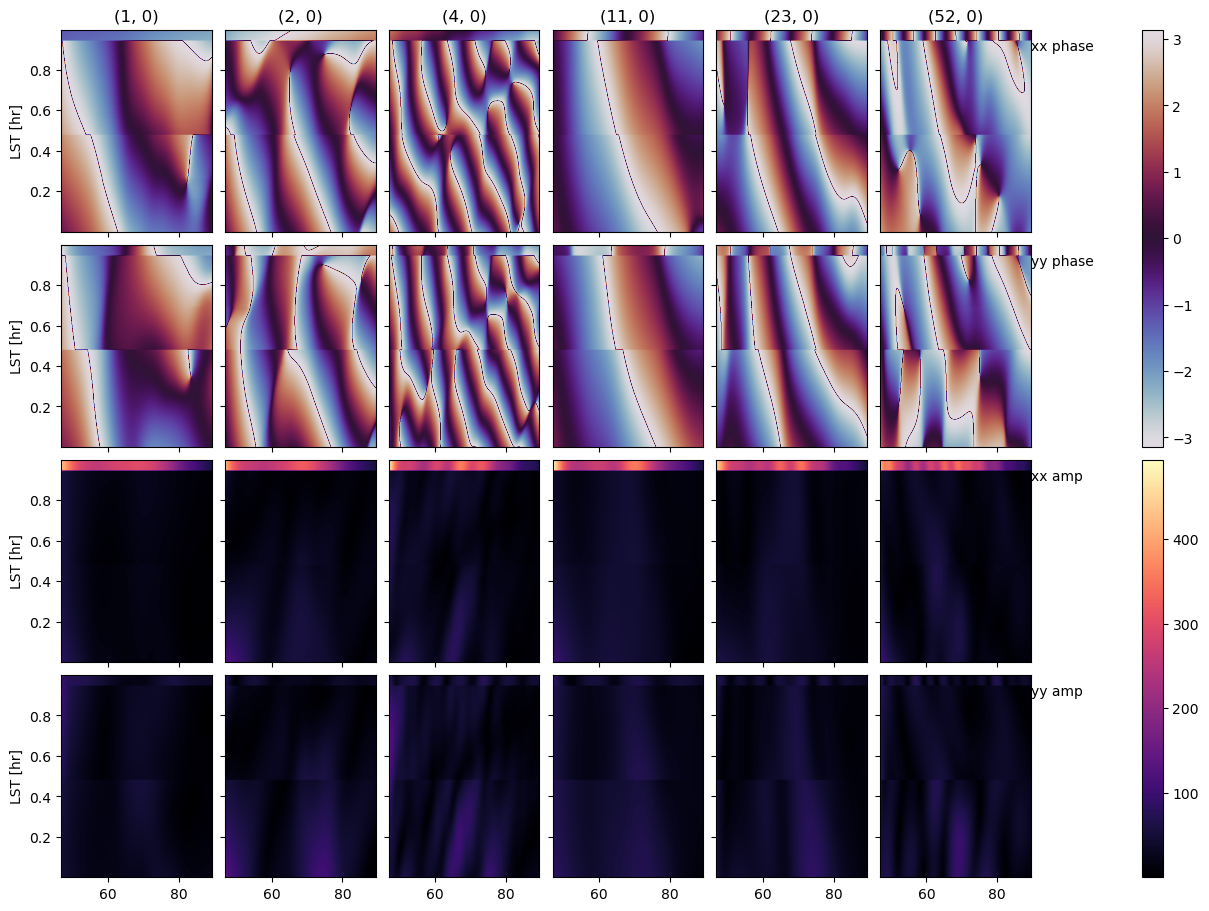

In [73]:
fig, ax = plt.subplots(4, len(blidx), constrained_layout=True, figsize=(12, 9), sharex=True, sharey=True)

extent = (freqs[0]/1e6, freqs[-1]/1e6, meta.lsts[0]*12/np.pi, meta.lsts[-1]*12/np.pi)
amp_clim = (np.min(np.abs(all_data)), np.max(np.abs(all_data)))
for j, bl in enumerate(antpairs):
    ax[0, j].set_title(bl)
    for pol in (0, 1):
        phs_img = ax[pol,j].imshow(np.angle(all_data[:, :, j, pol].T), cmap='twilight', aspect='auto', extent=extent, clim=(-np.pi, np.pi))
        amp_img = ax[pol+2, j].imshow(np.abs(all_data[:, :, j, pol].T), cmap='magma', aspect='auto', extent=extent, clim=amp_clim)

for i in range(4):
    ax[i,0].set_ylabel("LST [hr]")
    
fig.colorbar(phs_img, ax=ax[:2])
fig.colorbar(amp_img, ax=ax[2:])

ax[0, -1].text(1, 0.9,"xx phase",  transform=ax[0, -1].transAxes )
ax[1, -1].text(1, 0.9,"yy phase", transform=ax[1, -1].transAxes)
ax[2, -1].text(1, 0.9,"xx amp",transform=ax[2, -1].transAxes)
ax[3, -1].text(1, 0.9,"yy amp",transform=ax[3, -1].transAxes)


## Frequency-Based Inspection


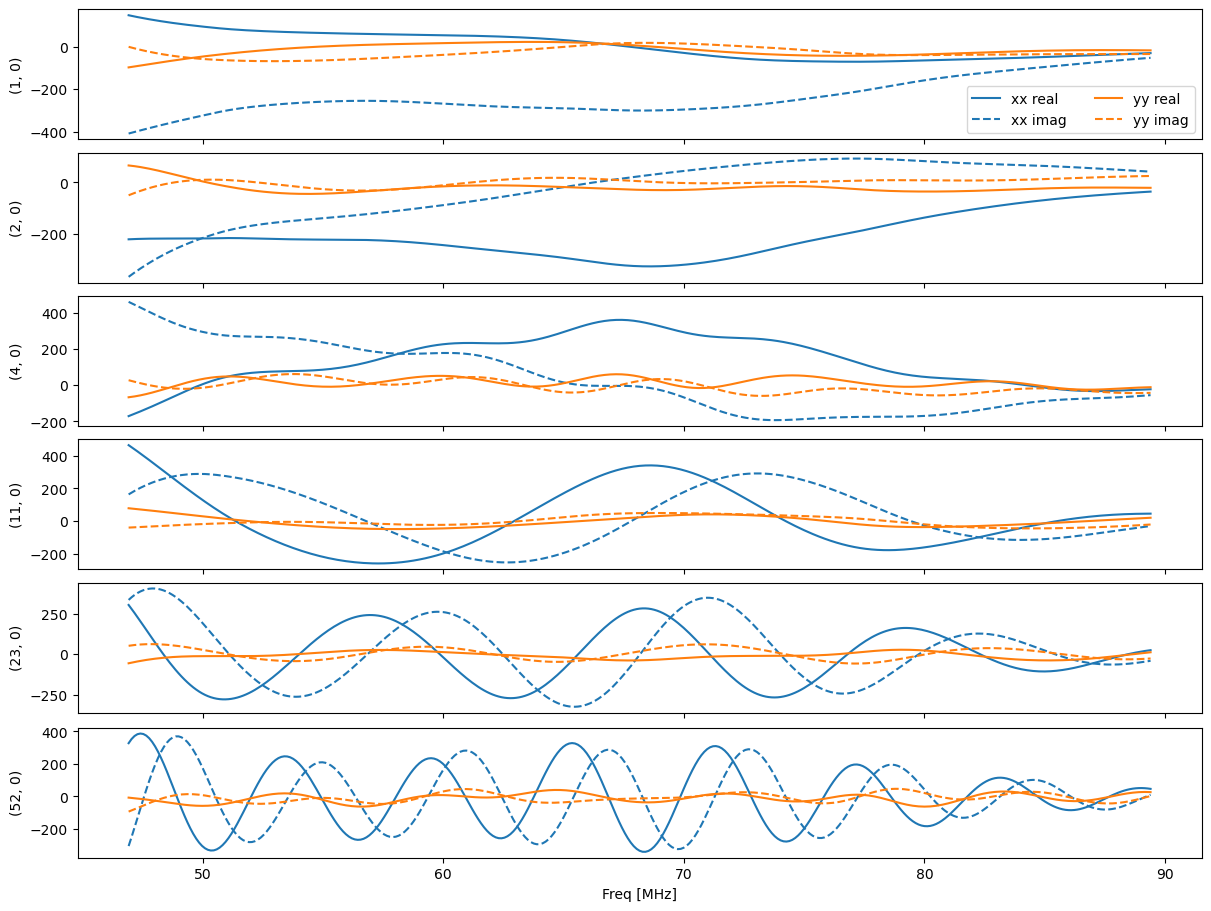

In [42]:
fig, ax = plt.subplots(len(blidx), 1, sharex=True, constrained_layout=True, figsize=(12, 9))

for i, p in enumerate(antpairs):
    for pol in (0, -1):
        ax[i].plot(freqs/ 1e6, all_data[:, 0, i, pol].real, ls='-', color=f'C{abs(pol)}', label=f'{meta.pols[pol]} real')
        ax[i].plot(freqs/ 1e6, all_data[:, 0, i, pol].imag, ls='--', color=f'C{abs(pol)}', label=f'{meta.pols[pol]} imag')
    ax[i].set_ylabel(str(p))
ax[-1].set_xlabel("Freq [MHz]")
ax[0].legend(ncols=2)

In [55]:
def get_delay_spec(d):
    p = np.abs(np.fft.fftshift(np.fft.fft(d*blackmanharris(len(d)))))**2
    tau = np.fft.fftshift(np.fft.fftfreq(len(d), d = freqs[1]-freqs[0]))*1e9
    
    # normalize
    p /= p.max()
    return p, tau
    

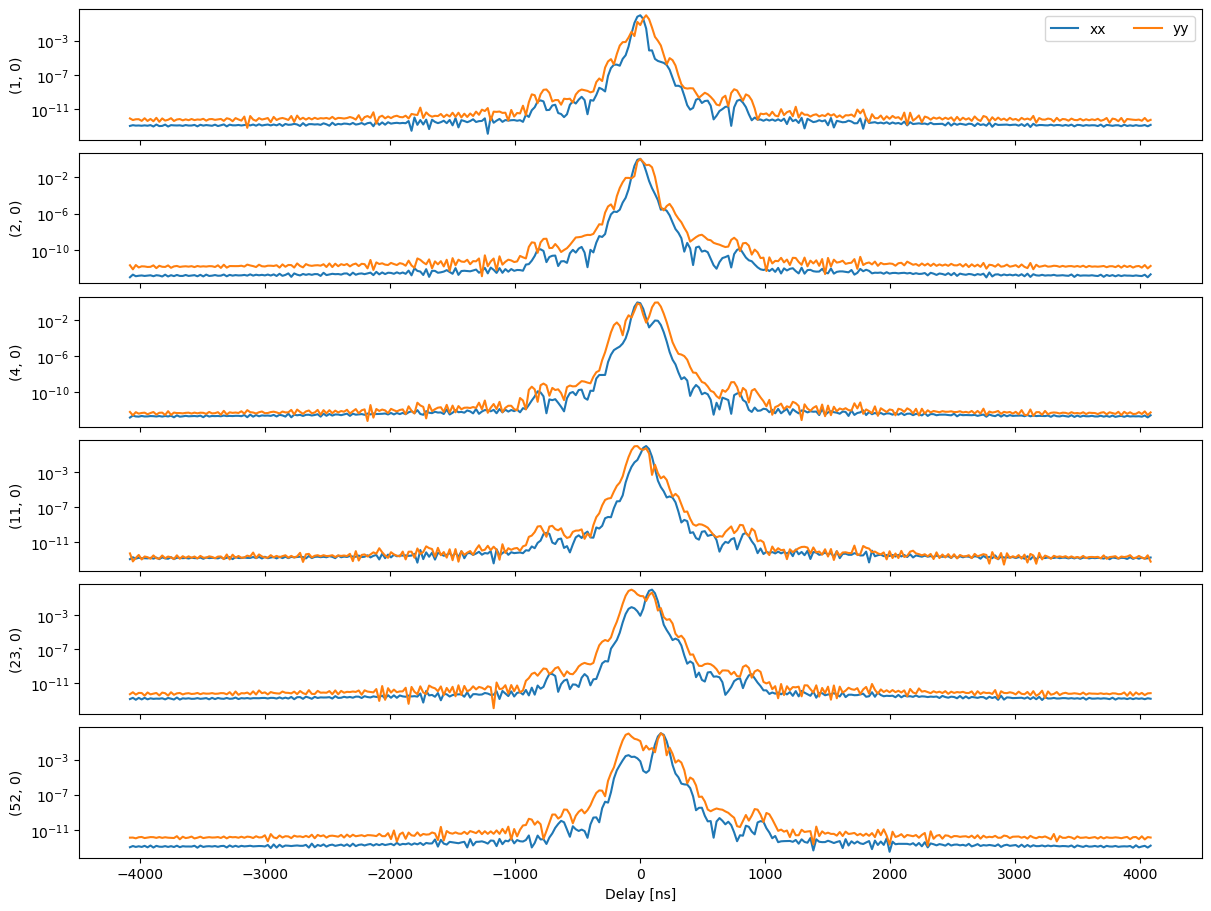

In [56]:
fig, ax = plt.subplots(len(blidx), 1, sharex=True, constrained_layout=True, figsize=(12, 9))

for i, p in enumerate(antpairs):
    for pol in (0, -1):
        pk, tau = get_delay_spec(all_data[:, 0, i, pol])
        ax[i].plot(tau, pk, color=f'C{abs(pol)}', label=f'{meta.pols[pol]}')
    ax[i].set_ylabel(str(p))
    ax[i].set_yscale('log')
ax[-1].set_xlabel("Delay [ns]")
ax[0].legend(ncols=2)

## Time-Based Inspection

In [4]:
from core.sky_model import make_ateam_model, make_gleam_like_model, ATEAM_MODEL_FILE, franzen_base, FranzenSourceCounts

In [5]:
import healpy as hp

In [97]:
hp.nside2npix(256)*hp.nside2pixarea(256) / (4*np.pi)

1.0

In [6]:
fr = FranzenSourceCounts(smin=1e-10, smax=1e4, npoints=10000)

In [20]:
source_counts = fr.with_bounds(
    smax=100
).with_nsources_per_pixel(
    nsources=1, nside=256
)

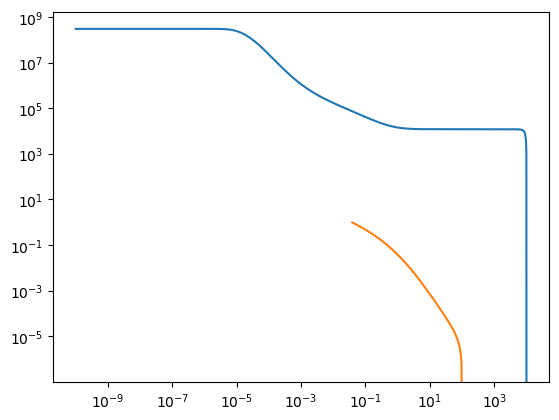

In [9]:
plt.loglog(fr.svec, fr._cdf)
plt.loglog(source_counts.svec, source_counts._cdf * hp.nside2pixarea(256))
#plt.loglog(self._base_svec[self._mask], self._cdf * pixarea)

In [21]:
source_counts.nbar * 4*np.pi

785998.0502620937

In [22]:
source_counts.smin

0.037779632217278133

In [23]:
source_counts._base_svec.shape

(10000,)

In [24]:
hp.nside2pixarea(256) * source_counts.cumulative_source_density.max()

0.9994482043737966

In [25]:
source_counts.cumulative_source_density.max() * 

SyntaxError: invalid syntax (1805697704.py, line 1)

In [39]:
counts, bins = np.histogram(xx, bins=source_counts.svec[::-1])

In [47]:
cdf = np.cumsum(counts[::-1])

In [38]:
np.diff(bins)

array([ -7, -26, -30, ...,   0,   0,   0])

In [43]:
np.sum(counts)

786201

In [35]:
cdf[0]

0.03790162809047188

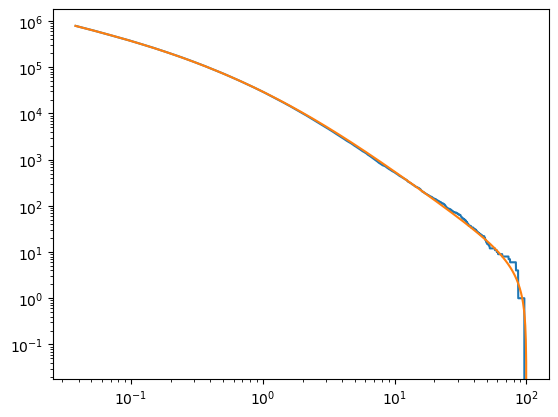

In [51]:
plt.loglog(bins[::-1][:-1], cdf)
plt.loglog(source_counts.svec, source_counts._cdf * 4*np.pi)

In [26]:
xx = source_counts.sample_fluxes(solid_angle=4*np.pi)

In [27]:
xx.shape

(786201,)

In [12]:
hp.nside2npix(256)

786432

In [52]:
ateam = SkyModel.from_file(ATEAM_MODEL_FILE)
#ateam.write_skyh5(ATEAM_MODEL_FILE, clobber=True)

In [53]:
ateam.stokes[0].min()

<Quantity 60. Jy>

In [54]:
xx.max()

96.04315005661357

In [82]:
ateam.stokes.shape

(4, 1, 10)

In [83]:
gleam_like = make_gleam_like_model(nside=256)

In [85]:
gleam_like.stokes.shape

(4, 1, 3235)

In [77]:
sky = SkyModel.from_skyh5("../sky_models/ptsrc256/fch0000.skyh5")

In [78]:
sky.stokes.shape

(4, 1, 3245)

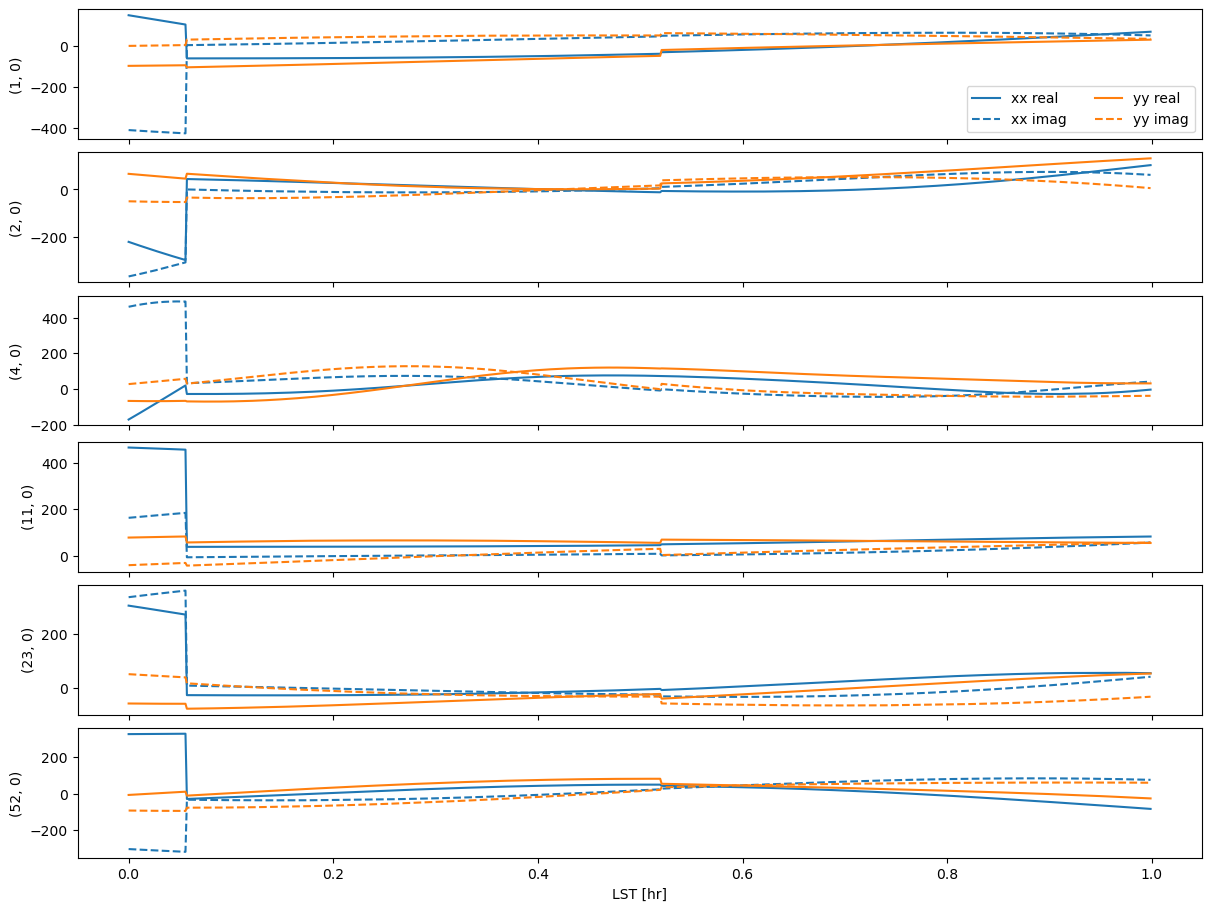

In [76]:
fig, ax = plt.subplots(len(blidx), 1, sharex=True, constrained_layout=True, figsize=(12, 9))

for i, p in enumerate(antpairs):
    for pol in (0, -1):
        ax[i].plot(meta.lsts * 12/np.pi, all_data[0, :, i, pol].real, ls='-', color=f'C{abs(pol)}', label=f'{meta.pols[pol]} real')
        ax[i].plot(meta.lsts * 12/np.pi, all_data[0,:, i, pol].imag, ls='--', color=f'C{abs(pol)}', label=f'{meta.pols[pol]} imag')
    ax[i].set_ylabel(str(p))
ax[-1].set_xlabel("LST [hr]")
ax[0].legend(ncols=2)